In [6]:
import pandas as pd
from nltk.corpus import stopwords
import re

In [2]:
df = pd.read_csv('../data/Zindi_Tech4MentalHealth/Train.csv')

In [3]:
df

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression
...,...,...,...
611,BOHSNXCN,What should I do to stop alcoholism?,Alcohol
612,GVDXRQPY,How to become my oldself again,Suicide
613,IO4JHIQS,How can someone stop it?,Alcohol
614,1DS3P1XO,I feel unworthy,Depression


In [7]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['new_text'] = df['text'].apply(clean_text)
df['new_text'] = df['new_text'].str.replace('\d+', '')

In [8]:
df

,ID,text,label,new_text
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,feel better dieam happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,get hallucinations
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,stresseed due lack financial support school
3,6UY7DX6Q,Why is life important?,Suicide,life important
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,could helped go depression
...,...,...,...,...
611,BOHSNXCN,What should I do to stop alcoholism?,Alcohol,stop alcoholism
612,GVDXRQPY,How to become my oldself again,Suicide,become oldself
613,IO4JHIQS,How can someone stop it?,Alcohol,someone stop
614,1DS3P1XO,I feel unworthy,Depression,feel unworthy


In [11]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['new_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 743 unique tokens.


In [14]:
from keras.preprocessing.sequence import pad_sequences

In [15]:
X = tokenizer.texts_to_sequences(df['new_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (616, 250)


In [16]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (616, 4)


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(554, 250) (554, 4)
(62, 250) (62, 4)


In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

In [25]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 498 samples, validate on 56 samples
Epoch 1/5
498/498 [==============================] - 2s 4ms/step - loss: 1.3039 - accuracy: 0.5261 - val_loss: 1.1534 - val_accuracy: 0.5357
Epoch 2/5
498/498 [==============================] - 2s 3ms/step - loss: 1.1310 - accuracy: 0.5843 - val_loss: 1.1249 - val_accuracy: 0.5357
Epoch 3/5
498/498 [==============================] - 2s 3ms/step - loss: 1.0772 - accuracy: 0.5843 - val_loss: 1.0966 - val_accuracy: 0.5357
Epoch 4/5
498/498 [==============================] - 2s 3ms/step - loss: 1.0585 - accuracy: 0.5843 - val_loss: 1.0796 - val_accuracy: 0.5357
Epoch 5/5
498/498 [==============================] - 2s 3ms/step - loss: 0.9988 - accuracy: 0.5843 - val_loss: 1.0338 - val_accuracy: 0.5357


In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

62/62 [==============================] - 0s 1ms/step
Test set
  Loss: 1.139
  Accuracy: 0.500


In [30]:
import matplotlib.pyplot as plt

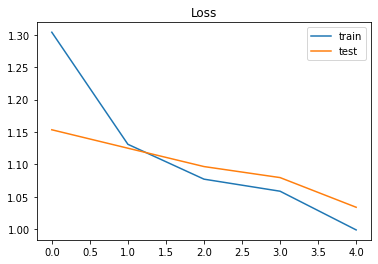

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

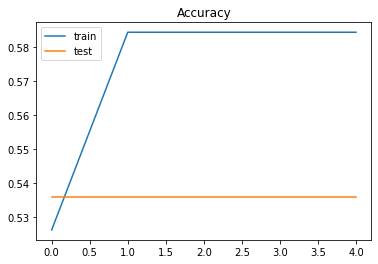

In [33]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [38]:
import numpy as np

In [39]:
np.unique(df['label'].values)

array(['Alcohol', 'Depression', 'Drugs', 'Suicide'], dtype=object)

In [40]:
new_complaint = ['life suicide stop sad']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = np.unique(df['label'].values)
print(pred, labels[np.argmax(pred)])

[[0.23148106 0.5307946  0.10965541 0.12806886]] Depression
